In [2]:
#Make necessary imports
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
!pip install patool
import patoolib
patoolib.extract_archive("Roms.rar")
clear_output()

In [4]:
!unzip /content/Roms/ROMS.zip
clear_output()

In [5]:
!python -m atari_py.import_roms /content/Roms/ROMS
clear_output()


**Processing game image**


In [6]:

from gym.core import ObservationWrapper
from gym.spaces import Box

# from scipy.misc import imresize
import cv2

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (84, 84)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        """what happens to each observation"""
        
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
        
        # resize image
        img = cv2.resize(img, self.img_size)
        
        img = img.mean(-1,keepdims=True)
        
        img = img.astype('float32') / 255.
              
        return img

**Frame buffer**

In [7]:
from gym.spaces.box import Box
from gym.core import Wrapper
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            """Multiply channels dimension by number of frames"""
            obs_shape = [height, width, n_channels * n_frames] 
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [8]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

#Instatntiate gym Atari-Breakout environment
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

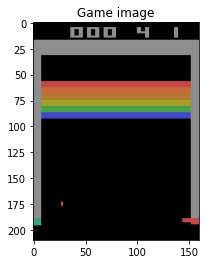

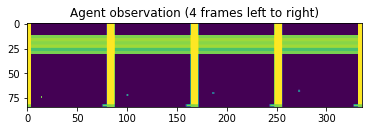

In [9]:
# review Atari image, and actual observation of the Agent after processing
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

**Building a network**



In [10]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [11]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, InputLayer

tf.reset_default_graph()

sess = tf.InteractiveSession()

Using TensorFlow backend.


In [12]:
from keras.layers import Conv2D, Dense, Flatten
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            self.network = keras.models.Sequential()

            self.network.add(Conv2D(32, (8, 8), strides=4, activation='relu',use_bias=False, input_shape=state_shape,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (4, 4), strides=2, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (3, 3), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(1024, (7, 7), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Flatten())
            self.network.add(Dense(n_actions, activation='linear',kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [13]:
tf.disable_eager_execution()
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
#Evaluate agents performance, in a number of games
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    s = env.reset()
    for _ in range(n_games):
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
         
            reward += r
            if done: 
              s = env.reset()
              break
          
        
        rewards.append(reward)
    return np.mean(rewards)

 **Experience replay**

In [15]:
import random

class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

In [16]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    
    # State at the beginning of rollout
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    reward = 0.0
    for t in range(n_steps):
        # get agent to pick action given state s
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        
        # add to replay buffer
        exp_replay.add(s, action, r, next_s, done)
        reward += r
        if done:
            s = env.reset()
        else:
            s = next_s
    return reward


**Target networks**

In [17]:
target_network = DQNAgent("target_network", state_dim, n_actions)

def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)

**Q-learning**

In [18]:
# Create placeholders that will be fed with exp_replay.sample(batch_size)

obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

In [19]:
# Take q-values for actions agent just took

current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

In [20]:
# compute q-values for NEXT states with target network
next_qvalues_target =  target_network.get_symbolic_qvalues(next_obs_ph)

# compute state values by taking max over next_qvalues_target for all actions
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done

# Define loss function for sgd.
td_loss = tf.reduce_mean(tf.losses.huber_loss(labels=reference_qvalues, predictions=current_action_qvalues))

optimizer=tf.train.AdamOptimizer(1e-5)
train_step = optimizer.minimize(td_loss, var_list=agent.weights)

sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# **Main loop**


In [43]:
# uncomment to load previous weights to keep training the agent
# agent.network.load_weights('/content/dqn_model_atari_weights_1.h5')

In [21]:
#Create the buffer and fill it.
exp_replay = ReplayBuffer(100000)
play_and_record(agent, env, exp_replay, n_steps=10000)

# take a sample batch of observations from the buffer
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

In [22]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

buffer size = 100000, epsilon = 0.13520
buffer size = 100000, epsilon = 0.13520


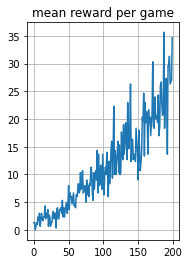

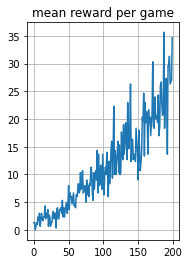

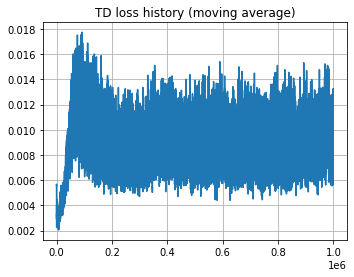

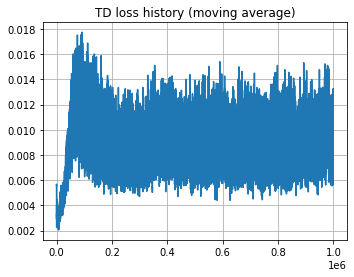

100%|██████████| 1000000/1000000 [10:00:56<00:00, 27.73it/s]



In [23]:
##Train the agent, configure the starting epsilon to one to encourage exploration
agent.epsilon=1
for i in trange(1000000):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train the network
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        load_weigths_into_target_network(agent, target_network)
        # reduce epsilon in every iteration until it reaches 1%
        agent.epsilon = max(agent.epsilon * 0.999, 0.01)
        

    if i % 5000 == 0:
      #uncomment to store agent's weights every some iterations
        agent.network.save_weights('/content/dqn_model_atari_weights_2.h5')
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        
    if i % 500 == 0:
        # plot mean reward per game and TD loss history
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

# Video

In [34]:
agent.epsilon=0

In [37]:
#record session on a video
import gym.wrappers
#configure directory to store videos
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)

# uncomment this part to load the model
# agent.network.load_weights('/content/dqn_model_atari_weights_1.h5')

sessions = [evaluate(env_monitor, agent, n_games=3) for _ in range(10)]
env_monitor.close()